In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import OneHotEncoder

# modeling
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import *
from sklearn.linear_model import LogisticRegression

#explainability
import shap

#serialization
import joblib
import csv 

#remove warnings
import warnings 
warnings.filterwarnings("ignore")

In [3]:
#read the data (to be downloaded locally by user of this notebook and store in a parent folder called "raw_data")
app_train = pd.read_csv("../raw_data/application_train.csv").astype("object")
app_test = pd.read_csv("../raw_data/application_test.csv").astype("object")


# Features Types

We need to convert variables that are not correctly cast as of float in the raw data : 

In [4]:
def convert_dtypes_func(df):
    '''
    Description : Setting correct dtypes of features.
    Input parameters : 
        1) df with features as 'object'
    Output : df with numerical features cast as float. 
    '''
    #List the columns to be converted to float
    list_columns_to_convert_to_float = ("CNT_CHILDREN" 
                                ,"AMT_INCOME_TOTAL" 
                                ,"AMT_CREDIT" 
                                ,"AMT_ANNUITY" 
                                ,"AMT_GOODS_PRICE" 
                                ,"DAYS_BIRTH"
                                ,"DAYS_EMPLOYED" 
                                ,"DAYS_REGISTRATION"
                                ,"REGION_RATING_CLIENT"
                                ,"REGION_POPULATION_RELATIVE"
                                ,"HOUR_APPR_PROCESS_START"
                                ,"CNT_FAM_MEMBERS" 
                                ,"DAYS_ID_PUBLISH"
                                ,"OWN_CAR_AGE"
                                ,"EXT_SOURCE_1               "
                                ,"EXT_SOURCE_2               "
                                ,"EXT_SOURCE_3               "
                                ,"APARTMENTS_AVG             "
                                ,"BASEMENTAREA_AVG           "
                                ,"YEARS_BEGINEXPLUATATION_AVG"
                                ,"YEARS_BUILD_AVG            "
                                ,"COMMONAREA_AVG             "
                                ,"ELEVATORS_AVG              "
                                ,"ENTRANCES_AVG              "
                                ,"FLOORSMAX_AVG              "
                                ,"FLOORSMIN_AVG              "
                                ,"LANDAREA_AVG               "
                                ,"LIVINGAPARTMENTS_AVG       "
                                ,"LIVINGAREA_AVG             "
                                ,"NONLIVINGAPARTMENTS_AVG    "
                                ,"NONLIVINGAREA_AVG          "
                                ,"APARTMENTS_MODE            "
                                ,"BASEMENTAREA_MODE          "
                                ,"YEARS_BEGINEXPLUATATION_MODE"
                                ,"YEARS_BUILD_MODE           "
                                ,"COMMONAREA_MODE            "
                                ,"ELEVATORS_MODE             "
                                ,"ENTRANCES_MODE             "
                                ,"FLOORSMAX_MODE             "
                                ,"FLOORSMIN_MODE             "
                                ,"LANDAREA_MODE              "
                                ,"LIVINGAPARTMENTS_MODE      "
                                ,"LIVINGAREA_MODE            "
                                ,"NONLIVINGAPARTMENTS_MODE   "
                                ,"NONLIVINGAREA_MODE         "
                                ,"APARTMENTS_MEDI            "
                                ,"BASEMENTAREA_MEDI          "
                                ,"YEARS_BEGINEXPLUATATION_MEDI"
                                ,"YEARS_BUILD_MEDI           "
                                ,"COMMONAREA_MEDI            "
                                ,"ELEVATORS_MEDI             "
                                ,"ENTRANCES_MEDI             "
                                ,"FLOORSMAX_MEDI             "
                                ,"FLOORSMIN_MEDI             "
                                ,"LANDAREA_MEDI              "
                                ,"LIVINGAPARTMENTS_MEDI      "
                                ,"LIVINGAREA_MEDI            "
                                ,"NONLIVINGAPARTMENTS_MEDI   "
                                ,"NONLIVINGAREA_MEDI         "
                                ,"TOTALAREA_MODE             "
                                ,"OBS_30_CNT_SOCIAL_CIRCLE   "
                                ,"DEF_30_CNT_SOCIAL_CIRCLE   "
                                ,"OBS_60_CNT_SOCIAL_CIRCLE   "
                                ,"DEF_60_CNT_SOCIAL_CIRCLE   "
                                ,"DAYS_LAST_PHONE_CHANGE     "
                                ,"AMT_REQ_CREDIT_BUREAU_HOUR"
                                ,"AMT_REQ_CREDIT_BUREAU_DAY "
                                ,"AMT_REQ_CREDIT_BUREAU_WEEK"
                                ,"AMT_REQ_CREDIT_BUREAU_MON "
                                ,"AMT_REQ_CREDIT_BUREAU_QRT "
                                ,"AMT_REQ_CREDIT_BUREAU_YEAR")       

    #remove spaces in the list created
    list_columns_to_convert_to_float = [s.strip() for s in list_columns_to_convert_to_float]       
    
    convert_count = 0

    #convert object columns to float
    for col in list_columns_to_convert_to_float:
        df[col] = df[col].astype(float)
        
        # Keep track of how many columns were label encoded
        convert_count += 1

    print('%d object columns were converted to float.' % convert_count)
    
    return df

# Feature Engineering

In [5]:
def feature_eng(df):
    '''
    Description : Creating new features based on business knowledge
    Input parameters : 
        1) df with numerical features cast as float
    Ouput : df with engineered features
    '''

    # Create an anomalous flag column
    df['DAYS_EMPLOYED_ANOM'] = df["DAYS_EMPLOYED"] == 365243

    # Replace the anomalous values with nan
    df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

    #correct sign of Days Birth
    df["DAYS_BIRTH"] = abs(df["DAYS_BIRTH"])
    df['AGE_INT'] = round((df['DAYS_BIRTH'] / 365).astype(float),2)

    #footing financial ratios
    df['annuity_income_ratio'] = round((df['AMT_INCOME_TOTAL'] / df['AMT_ANNUITY']).astype(float),2)
    df['credit_annuity_ratio'] = round((df['AMT_CREDIT'] / df['AMT_ANNUITY']).astype(float),2)
    df['credit_goods_price_ratio'] = round((df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']).astype(float),2)
    df['credit_downpayment'] = round((df['AMT_GOODS_PRICE'] - df['AMT_CREDIT']).astype(float),2)
 
    print('Feature engineering success')
   
    return df

# Feature Selection

In [6]:
def df_feature_selection(df):
    columns_list = df.columns.to_list()

    columns_to_drop_intersec = (['DAYS_BIRTH',
    'REGION_RATING_CLIENT_W_CITY',
    'BASEMENTAREA_MODE',
    'YEARS_BUILD_MODE',
    'COMMONAREA_MODE',
    'ELEVATORS_MODE',
    'ENTRANCES_MODE',
    'FLOORSMAX_MODE',
    'LANDAREA_MODE',
    'LIVINGAPARTMENTS_MODE',
    'NONLIVINGAPARTMENTS_MODE',
    'NONLIVINGAREA_MODE',
    'APARTMENTS_MEDI',
    'BASEMENTAREA_MEDI',
    'YEARS_BEGINEXPLUATATION_MEDI',
    'YEARS_BUILD_MEDI',
    'COMMONAREA_MEDI',
    'ELEVATORS_MEDI',
    'ENTRANCES_MEDI',
    'FLOORSMAX_MEDI',
    'FLOORSMIN_MEDI',
    'LIVINGAPARTMENTS_MEDI',
    'LIVINGAREA_MEDI',
    'NONLIVINGAPARTMENTS_MEDI',
    'NONLIVINGAREA_MEDI',
    'OBS_60_CNT_SOCIAL_CIRCLE',
    "DAYS_EMPLOYED_ANOM"])

    #Drop columns
    df_selec_col = pd.DataFrame(data=df, columns=columns_list).drop(columns_to_drop_intersec, axis=1)
    
    print('Feature selection success')

    return df_selec_col

# Imputation - Encoding - Standardization - Imputation

In [7]:
app_train = convert_dtypes_func(app_train)
app_train = feature_eng(app_train)
app_train = df_feature_selection(app_train)

#create df of features by type
cat_features = app_train.select_dtypes(include=['object']).drop(['SK_ID_CURR', 'TARGET'], axis=1)
num_features = app_train.select_dtypes(exclude=['object'])

#imputation
categorical_imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
cat_features = categorical_imputer.fit_transform(cat_features)

simple_imputer = SimpleImputer(missing_values=np.nan, strategy="median")
num_features = simple_imputer.fit_transform(num_features)

#One hot encoding categorical variables
ohe = OneHotEncoder(handle_unknown='ignore')
cat_array = ohe.fit_transform(cat_features).todense()
cat_array = np.asarray(cat_array)

#Standard Scaling numerical variables
scaler = StandardScaler()
num_array = scaler.fit_transform(num_features)

#concatenate
X_train = np.concatenate([cat_array, num_array], axis=1)
y_train = app_train['TARGET'].astype(int)

#columns list after ohe
cat_features_list = list(app_train.select_dtypes(include=['object']).drop(['SK_ID_CURR','TARGET'], axis=1).columns)
#https://stackoverflow.com/questions/54570947/feature-names-from-onehotencoder
cat_features_list_after_ohe = ohe.get_feature_names(cat_features_list).tolist()
num_features_list_after_preproc = list(app_train.select_dtypes(exclude=['object']).columns)

#concatenate list of features
features_list_after_prepr = cat_features_list_after_ohe + num_features_list_after_preproc

#transform X into a dataframe with column names
ohe_dataframe = pd.DataFrame(X_train, columns=features_list_after_prepr)

71 object columns were converted to float.
Feature engineering success
Feature selection success


In [8]:
app_test = convert_dtypes_func(app_test)
app_test = feature_eng(app_test)
app_test = df_feature_selection(app_test)

#create df of features by type
cat_features = app_test.select_dtypes(include=['object']).drop(['SK_ID_CURR'], axis=1)
num_features = app_test.select_dtypes(exclude=['object'])

#imputation
cat_features = categorical_imputer.transform(cat_features)
num_features = simple_imputer.transform(num_features)

#One hot encoding categorical variables
cat_array = ohe.transform(cat_features).todense()
cat_array = np.asarray(cat_array)

#Standard Scaling numerical variables
num_array = scaler.transform(num_features)

#concatenate
X_test = np.concatenate([cat_array, num_array], axis=1)

#columns list after ohe
cat_features_list_test = list(app_test.select_dtypes(include=['object']).drop(['SK_ID_CURR'], axis=1).columns)
cat_features_list_after_ohe_test = ohe.get_feature_names(cat_features_list_test).tolist()
num_features_list_after_preproc_test = list(app_test.select_dtypes(exclude=['object']).columns)

#concatenate list of features
features_list_after_prepr_test = cat_features_list_after_ohe_test + num_features_list_after_preproc_test

#transform X into a dataframe with column names
ohe_dataframe_test = pd.DataFrame(X_test, columns=features_list_after_prepr_test)

71 object columns were converted to float.
Feature engineering success
Feature selection success


In [9]:
#Model with best params
model = LogisticRegression(class_weight = 'balanced', C=0.001, max_iter=1000)

#fit
model.fit(X_train,y_train)

# #predict
# pred = model.predict_proba(X_test)
# y_pred = pred[:,1]

LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000)

In [10]:
# app_test["pred"] = y_pred
# app_test["pred"] = round(app_test["pred"].astype(np.float64),4)

In [11]:
#predict_proba returns the probability of the sample
#for each class in the model
#where classes are ordered as they are in self.classes_.
model.classes_

array([0, 1])

# SHAP

## Footing Shapley Explainer on Training Set

In [12]:
sub_sampled_train_data = shap.sample(ohe_dataframe, 50)
log_reg_explainer = shap.KernelExplainer(model.predict_proba, sub_sampled_train_data)

In [13]:
print(f'Shap Expected Value : {log_reg_explainer.expected_value}')

result_proba_training = model.predict_proba(X_train).mean(axis=0)
print(f'Model Mean Value (Theoretical Expected Value of default) : {result_proba_training[1]}')

Shap Expected Value : [0.51517367 0.48482633]
Model Mean Value (Theoretical Expected Value of default) : 0.424088441104478


## Prediction on Test Data and Shap Values

In [14]:
df_test = app_test.sample(frac=0.05, random_state=0)
df_test.to_csv("./dashboard_data/df_test.csv", index=False)

df_test_cat_features = df_test.select_dtypes(include=["object"]).drop(["SK_ID_CURR"], axis=1)
df_test_num_features = df_test.select_dtypes(exclude=['object'])

list_cat_features = df_test_cat_features.columns.to_list()
list_num_features = df_test_num_features.columns.to_list()

In [15]:
ohe = joblib.load("./bin/ohe.joblib")
categorical_imputer = joblib.load("./bin/categorical_imputer.joblib")
simple_imputer = joblib.load("./bin/simple_imputer.joblib")
scaler = joblib.load("./bin/scaler.joblib")
model = joblib.load("./bin/model.joblib")

#SimpleImputing (most frequent) and ohe of categorical features
cat_array = categorical_imputer.transform(df_test[list_cat_features])
cat_array = ohe.transform(cat_array).todense()

#SimpleImputing (median) and StandardScaling of numerical features
num_array = simple_imputer.transform(df_test[list_num_features])
num_array = scaler.transform(num_array)

#concatenate
X = np.concatenate([cat_array, num_array], axis=1)
X = np.asarray(X)

#predict
result_proba = model.predict_proba(X)
y_pred_proba = result_proba[:,1]

#cat columns list after ohe
cat_features_list_after_ohe = ohe.get_feature_names(list_cat_features).tolist()

#concatenate list of features
features_list_after_prepr_test = cat_features_list_after_ohe + list_num_features

#transform X into a dataframe with column names
ohe_dataframe_test = pd.DataFrame(X, columns=features_list_after_prepr_test)



In [16]:
sample_idx = 0
sub_sampled_test_data = ohe_dataframe.iloc[sample_idx,:].values.reshape(1,-1)

In [17]:
shap_vals = log_reg_explainer.shap_values(sub_sampled_test_data)

  0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
print("Model prediction for test data", model.predict_proba(sub_sampled_test_data))

shap.initjs()
#https://shap-lrjball.readthedocs.io/en/latest/generated/shap.force_plot.html
shap.force_plot(base_value=log_reg_explainer.expected_value[1],
                shap_values=shap_vals[1][0],
                features=sub_sampled_test_data[0],
                feature_names=features_list_after_prepr_test
)

Model prediction for test data [[0.04981177 0.95018823]]


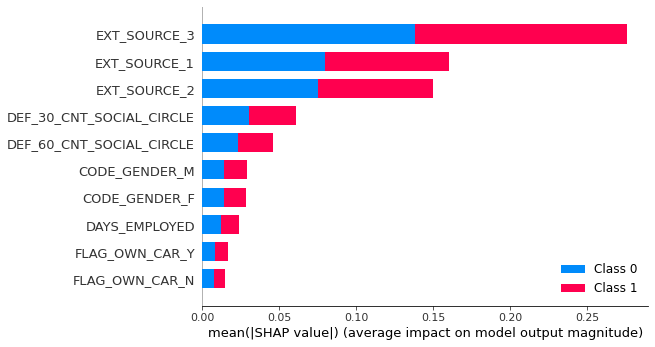

In [20]:
#https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html
shap.summary_plot(shap_values=shap_vals, 
                  features=sub_sampled_test_data, 
                  feature_names=features_list_after_prepr_test, 
                  max_display=10)

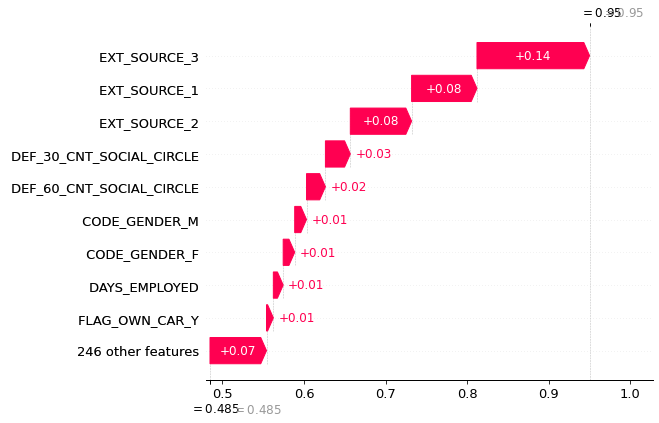

In [21]:
shap.plots._waterfall.waterfall_legacy(log_reg_explainer.expected_value[1],#expected_value,
                                       shap_vals[1][0],
                                       sub_sampled_test_data[0],
                                       feature_names=features_list_after_prepr_test,
                                       max_display=10)

# Export DataSet

Export pre-processed dataset to be used for Dashboard Streamlit (on which heroku deployed model will predicting scoring) : 
- Sample 1% of the labelled dataset (app_train)
- Sample 5% of the unlabelled dataset (app_test)

In [19]:
#labelled dataset
df_train = app_train.sample(frac=0.01, random_state=0)
df_train.to_csv("./dashboard_data/df_train.csv", index=False)
print('df_train exported to dashboard_data folder.')

#Unlabelled dataset
df_test = app_test.sample(frac=0.05, random_state=0)
df_test.to_csv("./dashboard_data/df_test.csv", index=False)

#export datasets of variables per type in order to prevent features type 
#change during csv reading in api.py
df_test_cat_features = df_test.select_dtypes(include=["object"]).drop(["SK_ID_CURR"], axis=1)
df_test_num_features = df_test.select_dtypes(exclude=['object'])

df_test_cat_features.to_csv("./dashboard_data/df_test_cat_features.csv", index=False)
df_test_num_features.to_csv("./dashboard_data/df_test_num_features.csv", index=False)

print('df_test exported to dashboard_data folder.')


df_train exported to dashboard_data folder.
df_test exported to dashboard_data folder.


# Serialization

In [24]:
joblib.dump(ohe, 'bin/ohe.joblib') #into a folder bin (for binary)
joblib.dump(categorical_imputer, 'bin/categorical_imputer.joblib')
joblib.dump(simple_imputer, 'bin/simple_imputer.joblib')
joblib.dump(scaler, 'bin/scaler.joblib')
joblib.dump(model, 'bin/model.joblib')

['bin/model.joblib']

# Pydantic Documentation

In [ ]:
# from pydantic import BaseModel, create_model, Field, ValidationError

# model = {}
# for i in range(len(app_train.dtypes)):
#     name = app_train.dtypes.index[i]
#     var_type = type(app_train.iloc[0, i])
#     model.update({name: (var_type, Field(...))})    

In [ ]:
# del model["SK_ID_CURR"]
# del model["TARGET"]
# # del model["DAYS_EMPLOYED_ANOM"]

In [ ]:
# data_dict = joblib.dump(model, 'bin/data_dict.joblib')

# DEBUG